## 推荐系统实用工具包与评估分析
- surprise工具包简单使用介绍
- 常用模型评估与分析方法介绍
- 使用recmetrics工具包来完成分析与基本绘图展示

![title](2.png)

### 安装好工具包：
- pip install recmetrics -i https://pypi.tuna.tsinghua.edu.cn/simple
- pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

需要修改下源码（有bug...）
- 路径：E:\ProgramData\Anaconda3\Lib\site-packages\recmetrics 修改plot.py源码
- 把：from sklearn.utils.fixes import signature 替换成 from funcsigs import signature

### 下载数据集
- https://grouplens.org/datasets/movielens/20m/
- 只需要解压其中ratings.csv与movies.csv到当前代码路径就可以

导入所需工具包

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

加载评分数据，由于数据比较多，过滤筛选其中一部分

In [2]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
#评分超过1000部的用户才留下，咱们数据多。。。
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

得到当前这批用户

In [5]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head()

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


movies.csv中包括电影名字及其对应ID以及电影所属题材

In [6]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
#得到电影题材特征
rated_movies = ratings.movieId.tolist()
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

制作题材特征

In [8]:
movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies.head()

,movieId,0,1,2,3,4,5,6,7,8,9
0,1,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,2,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,3,Comedy,Romance,None,None,None,None,None,None,None,None
3,4,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,5,Comedy,None,None,None,None,None,None,None,None,None


In [9]:
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) #id_vars不需要转换的，value_vars需要转换的
movies.head()

,movieId,variable,value
0,1,0,Adventure
1,2,0,Adventure
2,3,0,Comedy
3,4,0,Comedy
4,5,0,Comedy


In [10]:
movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Long Tail绘图
- 直接使用工具包recmetrics函数即可
- percentage是红色虚线取的百分比

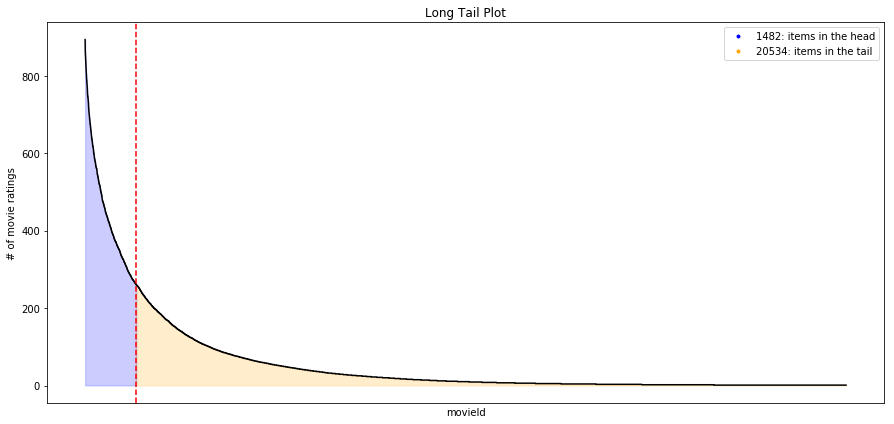

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

### 使用surprise工具包构建推荐系统

- https://surprise.readthedocs.io/en/stable/getting_started.html

In [11]:
#制作surprise包所需格式数据
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# 切分数据集
trainset, testset = train_test_split(data, test_size=0.25)

In [12]:
#用SVD来做
algo = SVD()
algo.fit(trainset)

In [13]:
#测试
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'predictions']
test.head()

,userId,movieId,actual,predictions
0,90078,3997,3.0,3.508206
1,35227,91529,4.5,4.103721
2,105580,3822,4.0,3.261920
3,23173,26915,3.0,3.377029
4,118205,4330,4.0,3.621114


In [14]:
#MSE与RMSE评估指标
print(recmetrics.mse(test.actual, test.predictions))
print(recmetrics.rmse(test.actual, test.predictions))

0.266437401383308
0.5161757466050764


In [15]:
#创建模型（对应的表格）
cf_model = test.pivot_table(index='userId', columns='movieId', values='predictions').fillna(0)

In [27]:
cf_model.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,131126,131134,131138,131142,131158,131174,131176,131231,131250,131252
userId,,,,,,,,,,,,,,,,,,,,,
156,0.000000,0.0,0.0,0.0,0.0,4.131413,0.0,0.0,3.4672,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.153592,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.000000,0.0,0.0,0.0,0.0,3.941351,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [17]:
#测试下推荐
get_users_predictions(156, 10, cf_model)

[1198, 5952, 1210, 480, 3578, 47, 1234, 590, 296, 1610]

In [18]:
#批量测试结果
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
156,"[6, 9, 17, 2067, 21, 4118, 24, 25, 2078, 4126,...","[1198, 5952, 1210, 480, 3578, 47, 1234, 590, 2..."
208,"[1, 6659, 517, 55814, 2567, 3079, 2571, 1036, ...","[912, 318, 5291, 593, 6016, 1254, 1148, 898, 1..."
359,"[33794, 6659, 32770, 2565, 37382, 45062, 1544,...","[318, 260, 1198, 2028, 50, 2019, 4226, 1148, 2..."
394,"[509, 1537, 3588, 6662, 5641, 4617, 3083, 527,...","[750, 1221, 1252, 608, 908, 1230, 3739, 912, 1..."
572,"[1029, 5125, 4105, 91658, 3081, 77837, 4623, 1...","[7153, 50, 47, 58559, 1270, 356, 5952, 4226, 1..."


为了对比实验，再加几种推荐结果

In [19]:
#排行榜
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[6, 9, 17, 2067, 21, 4118, 24, 25, 2078, 4126,...","[1198, 5952, 1210, 480, 3578, 47, 1234, 590, 2...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[1, 6659, 517, 55814, 2567, 3079, 2571, 1036, ...","[912, 318, 5291, 593, 6016, 1254, 1148, 898, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[33794, 6659, 32770, 2565, 37382, 45062, 1544,...","[318, 260, 1198, 2028, 50, 2019, 4226, 1148, 2...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[509, 1537, 3588, 6662, 5641, 4617, 3083, 527,...","[750, 1221, 1252, 608, 908, 1230, 3739, 912, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[1029, 5125, 4105, 91658, 3081, 77837, 4623, 1...","[7153, 50, 47, 58559, 1270, 356, 5952, 4226, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


In [20]:
#随机选

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[6, 9, 17, 2067, 21, 4118, 24, 25, 2078, 4126,...","[1198, 5952, 1210, 480, 3578, 47, 1234, 590, 2...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2375, 32291, 3365, 1190, 74, 58559, 879, 1150..."
208,"[1, 6659, 517, 55814, 2567, 3079, 2571, 1036, ...","[912, 318, 5291, 593, 6016, 1254, 1148, 898, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[66665, 83349, 118924, 1784, 1275, 6936, 81083..."
359,"[33794, 6659, 32770, 2565, 37382, 45062, 1544,...","[318, 260, 1198, 2028, 50, 2019, 4226, 1148, 2...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[130842, 60948, 1912, 15, 7218, 8252, 2639, 26..."
394,"[509, 1537, 3588, 6662, 5641, 4617, 3083, 527,...","[750, 1221, 1252, 608, 908, 1230, 3739, 912, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2029, 1255, 5300, 5316, 6062, 999, 44191, 121..."
572,"[1029, 5125, 4105, 91658, 3081, 77837, 4623, 1...","[7153, 50, 47, 58559, 1270, 356, 5952, 4226, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[27801, 99114, 3702, 3740, 2568, 3190, 1912, 7..."


### Top K推荐中的Precision与Recall

![title](1.png)

- 设置3.5为是否相关的阈值，所有相关的商品有：1，5,10
- 推荐系统返回的top3为：7,5,10
- 在结果（7,5,10）中正确的只有（5,10）
- 其中Precision @ 3 = （5,10）/（7,5,10） = 66.67% 返回结果中正确的有多少
- Recall@3  = （5,10）/（1,5,10） = 66.67% 返回结果中占所有相关的比例有多少

### 覆盖率

In [22]:
def prediction_coverage(predicted, catalog):
    """
    Computes the prediction coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    prediction_coverage:
        The prediction coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

In [23]:
catalog = ratings.movieId.unique().tolist()
random_coverage = prediction_coverage(ran_recs, catalog)
pop_coverage = prediction_coverage(pop_recs, catalog)
cf_coverage = prediction_coverage(cf_recs, catalog)

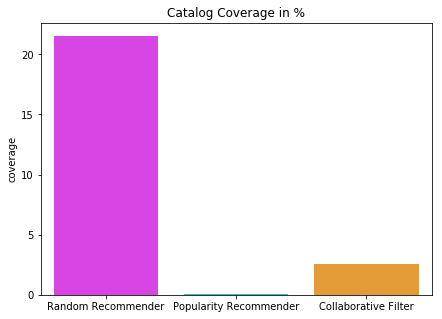

In [24]:
# 覆盖率
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)